# Customer Cart Abandonment

![alt text](shopping_cart.jpg "Title")

## Introduction
Abandonment is an e-commerce term used to describe a visitor on a web page who leaves that page before completing the desired action. Examples of abandonment include shopping cart abandonment, referring to visitors who add items to their online shopping cart, but exit without completing the purchase.

### Import Libraries

In [1]:
import pickle as pkl
import pandas as pd
import numpy as np
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix,accuracy_score,cohen_kappa_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from scipy.special import boxcox1p
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
%matplotlib inline

c:\users\avenger\appdata\local\programs\python\python36\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
c:\users\avenger\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
c:\users\avenger\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklea

## 1. Business Understanding
If a customer will visits the webpage then at that time we have to predict whether the customer will do abandonment or not. By doing so, we can give those customers some suitable offers so that cart abandonmet ratio will decrease which in terms increase in profits. 
There are few questions that we can able to answer by doing analysis:
1. If a customer is viewing the product details then what is the chance that he is doing cart abandonment?
2. What are the important factors related to cart abandonment?
3. How can we able to know whether a customer will do abandonment or not in future?

## 2. Data Understanding

### Read Dataset

In [2]:
dataset = pd.read_csv('data_cart_abandonment.csv')
dataset.head(3)


,ID,Is_Product_Details_viewed,Session_Activity_Count,No_Items_Added_InCart,No_Items_Removed_FromCart,No_Cart_Viewed,No_Checkout_Confirmed,No_Checkout_Initiated,No_Cart_Items_Viewed,No_Customer_Login,No_Page_Viewed,Customer_Segment_Type,Cart_Abandoned
0,Session_ID_0,Yes,4,1.0,0,0.0,0,0,1,0,0,0,1
1,Session_ID_1,No,38,0.0,0,2.0,0,0,2,0,2,0,1
2,Session_ID_2,No,8,5.0,0,0.0,1,1,1,0,0,1,0


In [3]:
dataset.dtypes

ID                            object
Is_Product_Details_viewed     object
Session_Activity_Count         int64
No_Items_Added_InCart        float64
No_Items_Removed_FromCart      int64
No_Cart_Viewed               float64
No_Checkout_Confirmed          int64
No_Checkout_Initiated          int64
No_Cart_Items_Viewed           int64
No_Customer_Login              int64
No_Page_Viewed                 int64
Customer_Segment_Type          int64
Cart_Abandoned                 int64
dtype: object

In [4]:
dataset.Cart_Abandoned=pd.Categorical(dataset.Cart_Abandoned)
dataset.Cart_Abandoned.dtypes

CategoricalDtype(categories=[0, 1], ordered=False)

In [5]:
dataset.Customer_Segment_Type=pd.Categorical(dataset.Customer_Segment_Type)

In [6]:
dataset.dtypes

ID                             object
Is_Product_Details_viewed      object
Session_Activity_Count          int64
No_Items_Added_InCart         float64
No_Items_Removed_FromCart       int64
No_Cart_Viewed                float64
No_Checkout_Confirmed           int64
No_Checkout_Initiated           int64
No_Cart_Items_Viewed            int64
No_Customer_Login               int64
No_Page_Viewed                  int64
Customer_Segment_Type        category
Cart_Abandoned               category
dtype: object

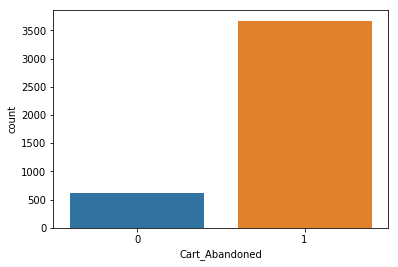

In [7]:
sns.countplot(dataset.Cart_Abandoned)

### EDA###########

##### Univariate#####

In [8]:
num=dataset.select_dtypes(include=["float64","int64"])
cat=dataset.select_dtypes(include=["object","category"]).drop(["ID"],axis=1)

In [9]:
num.shape

(4284, 9)

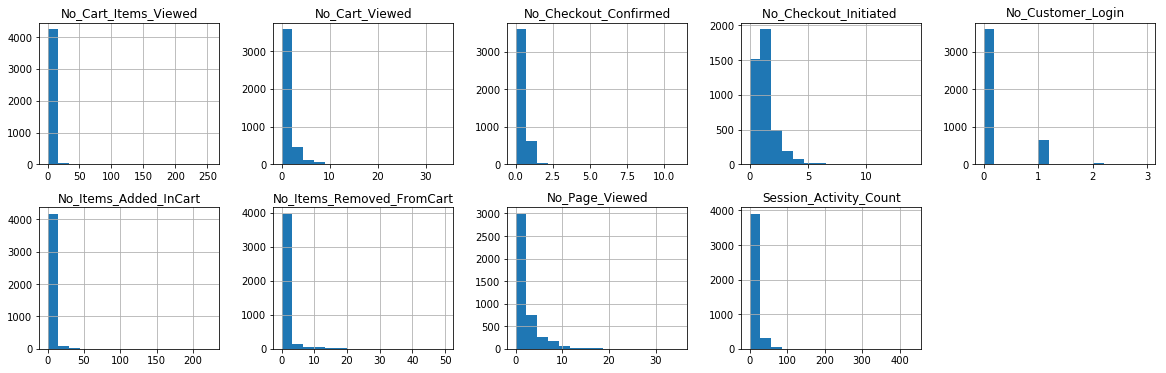

In [10]:
num.hist(bins=15, figsize=(20, 6), layout=(2, 5));

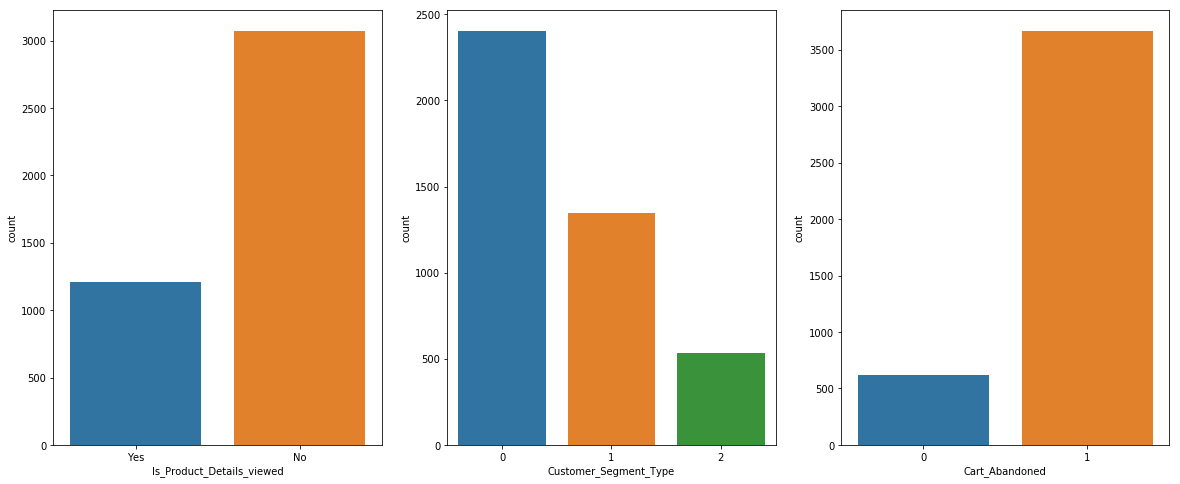

In [11]:
f, ax = plt.subplots(nrows=1,ncols=3,figsize=(20, 8))
for i,j in zip(cat.columns.tolist(), ax.flatten()):
    sns.countplot(x=cat[i],ax=j)

##### BiVariate#####

###### 1.FOR CATEGORICAL :Is_Product_Details_viewed Vrs Cart_Abandoned

#### Part 1 : If a customer is viewing the product details then what is the chance that he is doing cart abandonment?

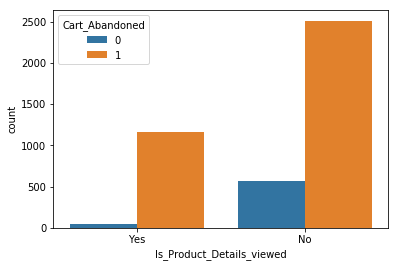

In [12]:
sns.countplot(x=dataset.Is_Product_Details_viewed,hue=dataset.Cart_Abandoned)

##### 2.1 FOR NUMERICAL : Numerical Attributes Vrs Cart_Abandoned : By BoxPlot

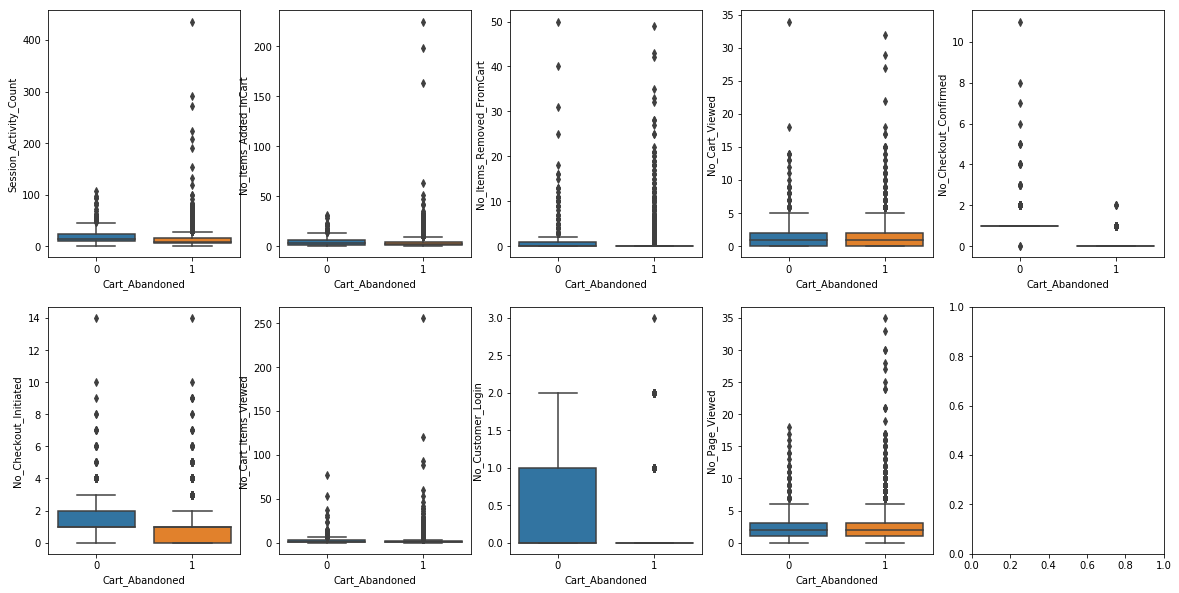

In [13]:
fig, ax = plt.subplots(2, 5, figsize=(20, 10))
for var, subplot in zip(num.columns.tolist(), ax.flatten()):
    sns.boxplot(x=cat["Cart_Abandoned"], y=num[var], ax=subplot)

##### 2.2 Correlation plot of Independent attributes

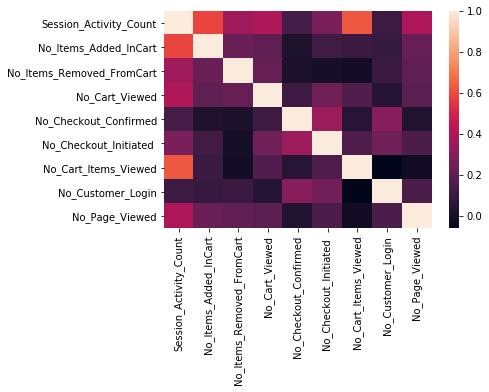

In [14]:
corr = num.corr()
sns.heatmap(corr)

## 3. Data Preparation

###### imputing missing values wherever needed

In [15]:
data = dataset.copy()

In [16]:
data.isna().sum()

ID                           0
Is_Product_Details_viewed    0
Session_Activity_Count       0
No_Items_Added_InCart        9
No_Items_Removed_FromCart    0
No_Cart_Viewed               9
No_Checkout_Confirmed        0
No_Checkout_Initiated        0
No_Cart_Items_Viewed         0
No_Customer_Login            0
No_Page_Viewed               0
Customer_Segment_Type        0
Cart_Abandoned               0
dtype: int64

In [17]:
null_col = data.columns[data.isna().any()].tolist()
null_col

['No_Items_Added_InCart', 'No_Cart_Viewed']

In [18]:
data[null_col].head()

,No_Items_Added_InCart,No_Cart_Viewed
0,1.0,0.0
1,0.0,2.0
2,5.0,0.0
3,0.0,2.0
4,14.0,1.0


In [21]:
data.isna().sum()

ID                           0
Is_Product_Details_viewed    0
Session_Activity_Count       0
No_Items_Added_InCart        0
No_Items_Removed_FromCart    0
No_Cart_Viewed               0
No_Checkout_Confirmed        0
No_Checkout_Initiated        0
No_Cart_Items_Viewed         0
No_Customer_Login            0
No_Page_Viewed               0
Customer_Segment_Type        0
Cart_Abandoned               0
dtype: int64

In [22]:
data.dtypes

ID                             object
Is_Product_Details_viewed      object
Session_Activity_Count          int64
No_Items_Added_InCart         float64
No_Items_Removed_FromCart       int64
No_Cart_Viewed                float64
No_Checkout_Confirmed           int64
No_Checkout_Initiated           int64
No_Cart_Items_Viewed            int64
No_Customer_Login               int64
No_Page_Viewed                  int64
Customer_Segment_Type        category
Cart_Abandoned               category
dtype: object

In [23]:
data[null_col] = data[null_col].astype("int64")

In [24]:
data.isna().sum()

ID                           0
Is_Product_Details_viewed    0
Session_Activity_Count       0
No_Items_Added_InCart        0
No_Items_Removed_FromCart    0
No_Cart_Viewed               0
No_Checkout_Confirmed        0
No_Checkout_Initiated        0
No_Cart_Items_Viewed         0
No_Customer_Login            0
No_Page_Viewed               0
Customer_Segment_Type        0
Cart_Abandoned               0
dtype: int64

###### 1.Taking care of Outliers by Normalizing the Data : By MinMax Normalization

In [25]:
num=data.select_dtypes(include=["int64"])
cat=data.select_dtypes(include=["object","category"]).drop(["ID"],axis=1)

In [26]:
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(num)
x_scaled

array([[0.00917431, 0.00444444, 0.        , ..., 0.00390625, 0.        ,
        0.        ],
       [0.08715596, 0.        , 0.        , ..., 0.0078125 , 0.        ,
        0.05714286],
       [0.01834862, 0.02222222, 0.        , ..., 0.00390625, 0.        ,
        0.        ],
       ...,
       [0.00917431, 0.00444444, 0.        , ..., 0.00390625, 0.        ,
        0.        ],
       [0.01834862, 0.01333333, 0.        , ..., 0.00390625, 0.        ,
        0.05714286],
       [0.07110092, 0.01777778, 0.        , ..., 0.02734375, 0.        ,
        0.02857143]])

In [27]:
df_scaled = pd.DataFrame(x_scaled,columns=num.columns)
df_scaled.head(3)

,Session_Activity_Count,No_Items_Added_InCart,No_Items_Removed_FromCart,No_Cart_Viewed,No_Checkout_Confirmed,No_Checkout_Initiated,No_Cart_Items_Viewed,No_Customer_Login,No_Page_Viewed
0,0.009174,0.004444,0.0,0.000000,0.000000,0.000000,0.003906,0.0,0.000000
1,0.087156,0.000000,0.0,0.058824,0.000000,0.000000,0.007812,0.0,0.057143
2,0.018349,0.022222,0.0,0.000000,0.090909,0.071429,0.003906,0.0,0.000000


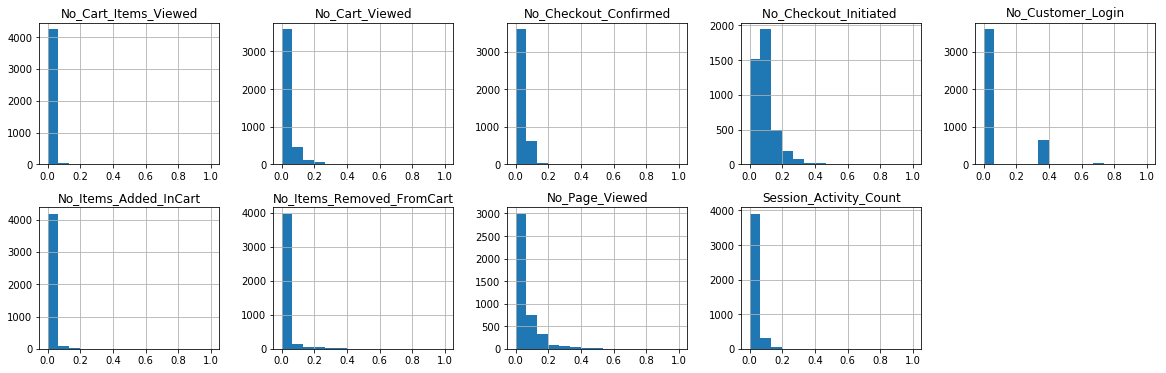

In [28]:
df_scaled.hist(bins=15, figsize=(20, 6), layout=(2, 5));

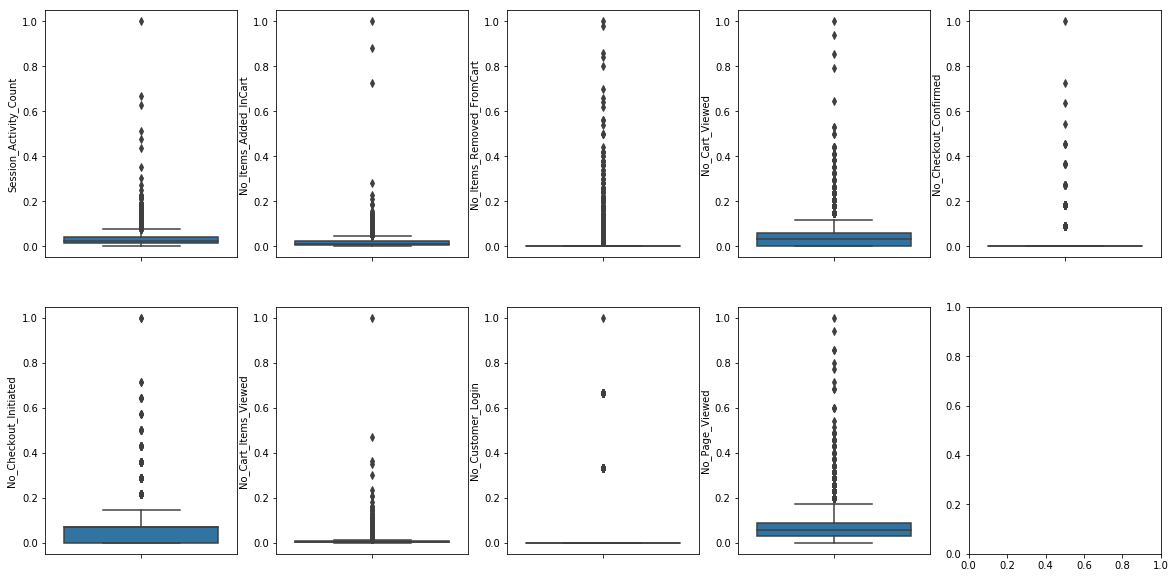

In [29]:
fig, ax = plt.subplots(2, 5, figsize=(20, 10))
for var, subplot in zip(df_scaled.columns.tolist(), ax.flatten()):
    sns.boxplot(y=df_scaled[var], ax=subplot)

###### 2.Taking care of Outliers by Normalizing the Data : By BoxCox Normalization

In [30]:

df_scaled_boxcox=boxcox1p(num, 0)


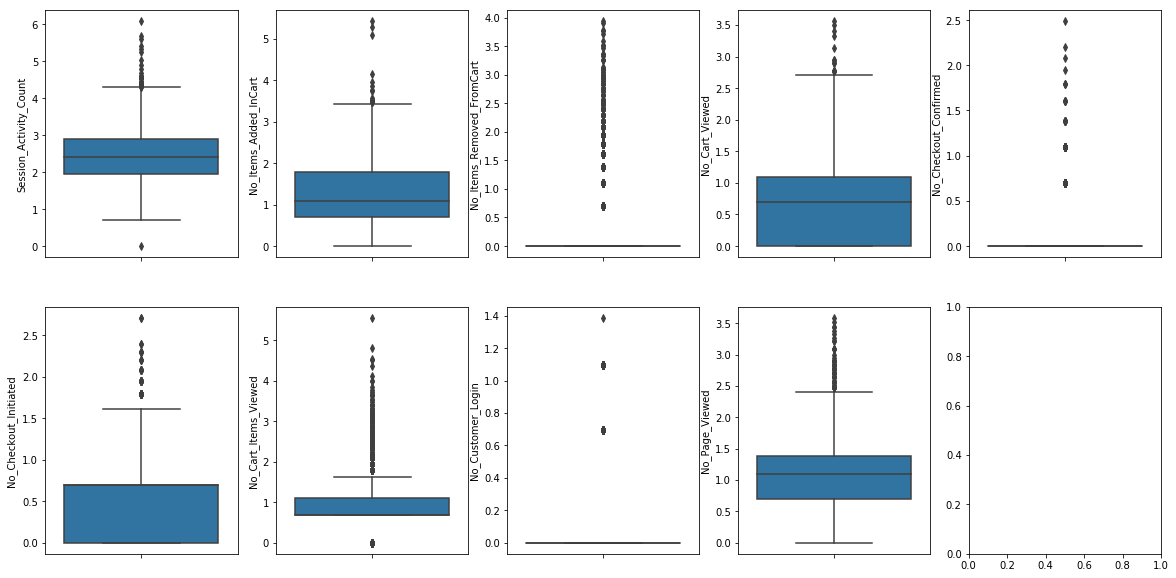

In [31]:
fig, ax = plt.subplots(2, 5, figsize=(20, 10))
for var, subplot in zip(df_scaled_boxcox.columns.tolist(), ax.flatten()):
    sns.boxplot(y=df_scaled_boxcox[var], ax=subplot)

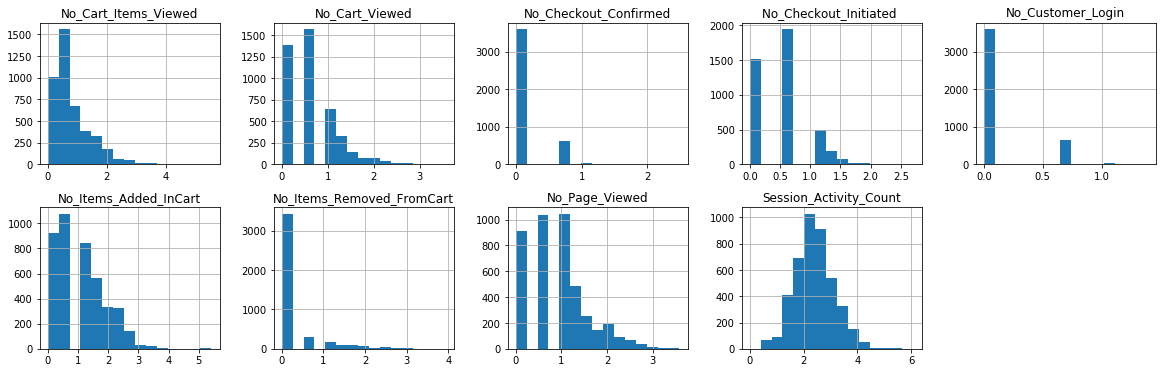

In [32]:
df_scaled_boxcox.hist(bins=15, figsize=(20, 6), layout=(2, 5));

In [33]:
df_scaled_boxcox.head(3)

,Session_Activity_Count,No_Items_Added_InCart,No_Items_Removed_FromCart,No_Cart_Viewed,No_Checkout_Confirmed,No_Checkout_Initiated,No_Cart_Items_Viewed,No_Customer_Login,No_Page_Viewed
0,1.609438,0.693147,0.0,0.000000,0.000000,0.000000,0.693147,0.0,0.000000
1,3.663562,0.000000,0.0,1.098612,0.000000,0.000000,1.098612,0.0,1.098612
2,2.197225,1.791759,0.0,0.000000,0.693147,0.693147,0.693147,0.0,0.000000


In [34]:
df_scaled_boxcox["ID"]=data.ID
df_scaled_boxcox.set_index('ID',inplace=True)


In [35]:
df_scaled_boxcox.reset_index(inplace=True)

In [36]:
df_final=df_scaled_boxcox.join(cat)
df_final.head(3)

,ID,Session_Activity_Count,No_Items_Added_InCart,No_Items_Removed_FromCart,No_Cart_Viewed,No_Checkout_Confirmed,No_Checkout_Initiated,No_Cart_Items_Viewed,No_Customer_Login,No_Page_Viewed,Is_Product_Details_viewed,Customer_Segment_Type,Cart_Abandoned
0,Session_ID_0,1.609438,0.693147,0.0,0.000000,0.000000,0.000000,0.693147,0.0,0.000000,Yes,0,1
1,Session_ID_1,3.663562,0.000000,0.0,1.098612,0.000000,0.000000,1.098612,0.0,1.098612,No,0,1
2,Session_ID_2,2.197225,1.791759,0.0,0.000000,0.693147,0.693147,0.693147,0.0,0.000000,No,1,0


In [37]:
df_final.Is_Product_Details_viewed.replace({"Yes":1,"No":0},inplace=True)
df_final.head(3)

,ID,Session_Activity_Count,No_Items_Added_InCart,No_Items_Removed_FromCart,No_Cart_Viewed,No_Checkout_Confirmed,No_Checkout_Initiated,No_Cart_Items_Viewed,No_Customer_Login,No_Page_Viewed,Is_Product_Details_viewed,Customer_Segment_Type,Cart_Abandoned
0,Session_ID_0,1.609438,0.693147,0.0,0.000000,0.000000,0.000000,0.693147,0.0,0.000000,1,0,1
1,Session_ID_1,3.663562,0.000000,0.0,1.098612,0.000000,0.000000,1.098612,0.0,1.098612,0,0,1
2,Session_ID_2,2.197225,1.791759,0.0,0.000000,0.693147,0.693147,0.693147,0.0,0.000000,0,1,0


In [38]:
df_final.dtypes

ID                             object
Session_Activity_Count        float64
No_Items_Added_InCart         float64
No_Items_Removed_FromCart     float64
No_Cart_Viewed                float64
No_Checkout_Confirmed         float64
No_Checkout_Initiated         float64
No_Cart_Items_Viewed          float64
No_Customer_Login             float64
No_Page_Viewed                float64
Is_Product_Details_viewed       int64
Customer_Segment_Type        category
Cart_Abandoned               category
dtype: object

In [40]:
df_final.Is_Product_Details_viewed=pd.Categorical(df_final.Is_Product_Details_viewed)

### Feature Selection

###### 1. By RFE

In [41]:
X=df_final.iloc[:,1:12]
X.shape

(4284, 11)

In [42]:
y=df_final["Cart_Abandoned"]
y.name

'Cart_Abandoned'

In [43]:
lr = LogisticRegression()
lr.fit(X,y)
#stop the search when only the last feature is left
rfe = RFE(lr, n_features_to_select=7, verbose = 3 )
fit=rfe.fit(X,y)
print("Num Features: %d"% fit.n_features_) 
print("Selected Features: %s"% fit.support_) 
print("Feature Ranking: %s"% fit.ranking_)



Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Num Features: 7
Selected Features: [ True False False  True  True  True False  True  True  True False]
Feature Ranking: [1 2 4 1 1 1 5 1 1 1 3]


In [44]:
l = [i for i,x in enumerate(list(fit.support_)) if x == True]

In [45]:
X.columns

Index(['Session_Activity_Count', 'No_Items_Added_InCart',
       'No_Items_Removed_FromCart', 'No_Cart_Viewed', 'No_Checkout_Confirmed',
       'No_Checkout_Initiated ', 'No_Cart_Items_Viewed', 'No_Customer_Login',
       'No_Page_Viewed', 'Is_Product_Details_viewed', 'Customer_Segment_Type'],
      dtype='object')

In [46]:
feature_selected = [X[X.columns[l[i]]].name for i,x in enumerate(l)]

In [47]:
feature_selected

['Session_Activity_Count',
 'No_Cart_Viewed',
 'No_Checkout_Confirmed',
 'No_Checkout_Initiated ',
 'No_Customer_Login',
 'No_Page_Viewed',
 'Is_Product_Details_viewed']

###### 2.By Random Forest Classifier

In [48]:
# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)

# Train the classifier
clf.fit(X, y)
feature_weightage_dict = dict()
# Print the name and gini importance of each feature
for feature in zip(X.columns, clf.feature_importances_):
    feature_weightage_dict.update({feature[0]:feature[1]})


In [49]:
feature_weightage_dict

{'Session_Activity_Count': 0.05052857005529642,
 'No_Items_Added_InCart': 0.025547984898027527,
 'No_Items_Removed_FromCart': 0.010172300692196705,
 'No_Cart_Viewed': 0.017810335296951977,
 'No_Checkout_Confirmed': 0.7341868777064404,
 'No_Checkout_Initiated ': 0.0441808380652188,
 'No_Cart_Items_Viewed': 0.018703955749515146,
 'No_Customer_Login': 0.05604221107820115,
 'No_Page_Viewed': 0.027120211503535017,
 'Is_Product_Details_viewed': 0.009764913736069736,
 'Customer_Segment_Type': 0.0059418012185472185}

In [50]:
sorted_feature_weightage_dict = sorted(feature_weightage_dict.items(), key=lambda kv: kv[1], reverse = True)

In [51]:
sorted_feature_weightage_dict

[('No_Checkout_Confirmed', 0.7341868777064404),
 ('No_Customer_Login', 0.05604221107820115),
 ('Session_Activity_Count', 0.05052857005529642),
 ('No_Checkout_Initiated ', 0.0441808380652188),
 ('No_Page_Viewed', 0.027120211503535017),
 ('No_Items_Added_InCart', 0.025547984898027527),
 ('No_Cart_Items_Viewed', 0.018703955749515146),
 ('No_Cart_Viewed', 0.017810335296951977),
 ('No_Items_Removed_FromCart', 0.010172300692196705),
 ('Is_Product_Details_viewed', 0.009764913736069736),
 ('Customer_Segment_Type', 0.0059418012185472185)]

In [52]:
df_final.columns

Index(['ID', 'Session_Activity_Count', 'No_Items_Added_InCart',
       'No_Items_Removed_FromCart', 'No_Cart_Viewed', 'No_Checkout_Confirmed',
       'No_Checkout_Initiated ', 'No_Cart_Items_Viewed', 'No_Customer_Login',
       'No_Page_Viewed', 'Is_Product_Details_viewed', 'Customer_Segment_Type',
       'Cart_Abandoned'],
      dtype='object')

#### Part 2: What are the important factors related to cart abandonment?
Now comparing both the models we can see the No_Items_Added_InCart, No_Checkout_Confirmed, No_Checkout_Initiated, No_Customer_Login and No_Page_Viewed has the higher feature importance. So we will only consider these features to train our model.

### Train-Validation Split

In [53]:
X = df_final.iloc[:,[5,6,8,9,2]]
y = df_final.loc[:,["Cart_Abandoned"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=0)


### Over-Sampling Using SMOTE

In [54]:
sm = SMOTE(random_state=2,k_neighbors=5)
X_train, y_train =sm.fit_sample(X_train,y_train)


c:\users\avenger\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\avenger\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


###### Train-Validation Split after SMOTE

In [55]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_train, y_train, test_size=0.40, random_state=0)

## 4. Model Builiding And Prediction

#### Part 3: How can we able to know whether a customer will do abandonment or not in future?

In [56]:
lr1 = LogisticRegression()
lr1.fit(X_train_new,y_train_new)



y_pred_new = lr1.predict(X_test_new)  #### For SMOTE validation samples
y_pred=lr1.predict(X_test)##### For actual validation samples





## 5. Evaluation

In [57]:
print(" accuracy is %2.3f" % accuracy_score(y_test_new, y_pred_new))
print(" Kappa is %f" %cohen_kappa_score(y_test_new, y_pred_new))


 accuracy is 0.988
 Kappa is 0.976122


In [58]:
print(" accuracy is %2.3f" % accuracy_score(y_test, y_pred))
print(" Kappa is %f" %cohen_kappa_score(y_test, y_pred))


 accuracy is 0.984
 Kappa is 0.936154


### Dump model to pickle file

In [59]:
lr1.predict(X_test)

array([1, 1, 1, ..., 0, 1, 1], dtype=int64)

In [60]:
pkl_out = open("train_classifier","wb")
pkl.dump(lr1,pkl_out)

## 6. Conclusion
By using this analysis we can predict whether a customer will do abandonment or not in the future. So that we can able to give them some offers so that they able to complete the checkout successfully.